In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%writefile kaggle.json
{"username":"sofiabotechia","key":"ced387e57e85c94b23583b3b36b0ae5e"}

Writing kaggle.json


In [3]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


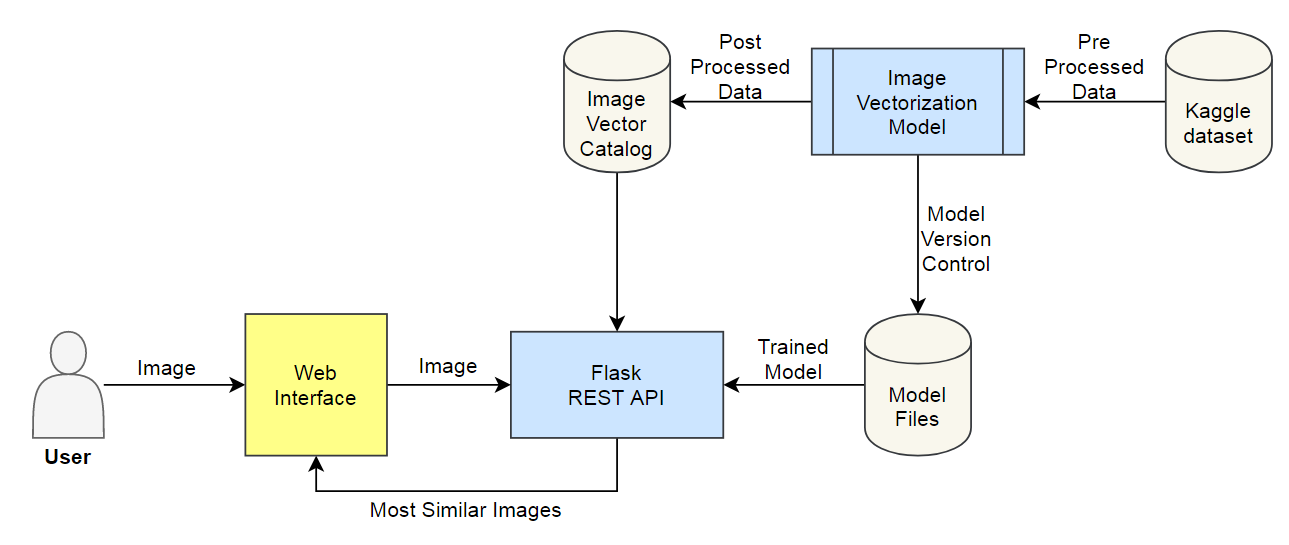

### Choice of variables

- Image Encoder: Any pre-trained image classification model can be selected. Here, I'm using the [BiT-M-50x3](https://tfhub.dev/google/bit/m-r50x3/1) model because of its performance.
- Vector Similarity System: Images are represented in a fixed-length feature vector format. For the given input vector, we need to find the TopK most similar vectors, keeping the memory efficiency and real-time retrival objective in mind.
The most popular techniques are: Annoy, Cosine distance, L1 distance, Locally Sensitive Hashing (LSH) and Image Deep Ranking. I selected [Annoy](https://github.com/spotify/annoy) because of its fast and efficient nature.
- Dataset: This system is able to handle all kind of image dataset. Only the basic preprocessing (in step 1) would need some modifications depending on the dataset. I chose [Fashion Product Images Dataset](https://www.kaggle.com/bhaskar2443053/fashion-small?).

### 1. Data Acquisition

Download the raw image dataset into a directory. Categorize these images into their respective category directories. Make sure that images are of the same type, JPEG recommended. We will also process the metadata and store it in a serialized file, CSV recommended.

In [4]:
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/image

In [5]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:18<00:00, 224.34it/s]

Moved 44441 images.


### Step 2: Encoder Fine-tuning [optional]

Download the pre-trained image model and add two additional layers on top of that: the first layer is a feature vector layer and the second layer is the classification layer. We will only train these 2 layers on our data and after training, we will select the feature vector layer as the output of our fine-tuned encoder. After fine-tuning the model, we will save the feature extractor for later use.

In [31]:
!pip install --quiet --upgrade "tensorflow==2.19.0" "jax==0.5.1" "jaxlib==0.5.1" --no-cache-dir

In [21]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.19.0
Hub version: 0.16.1
GPU is available


In [22]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [24]:
data_dir = '/content/Fashion_data/categories'

In [25]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [33]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

# Wrapper to adapt Hub layer to new Keras 3 API
class HubLayer(keras.layers.Layer):
    def __init__(self, handle, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self._hub_layer = hub.KerasLayer(handle, trainable=trainable)

    def call(self, inputs):
        return self._hub_layer(inputs)

print("Building model with", MODULE_HANDLE)

model = keras.Sequential([
    keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    HubLayer(MODULE_HANDLE, trainable=False),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(N_FEATURES,
                       kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(train_generator.num_classes,
                       kernel_regularizer=keras.regularizers.l2(0.0001))
])
model.build((None,) + IMAGE_SIZE + (3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hub_layer (HubLayer)            │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,573,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,574,919 (6.01 MB)

 Trainable params: 1,574,919 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
   1/1111 ━━━━━━━━━━━━━━━━━━━━ 43:08:41 140s/step - accuracy: 0.1250 - loss: 6.1795

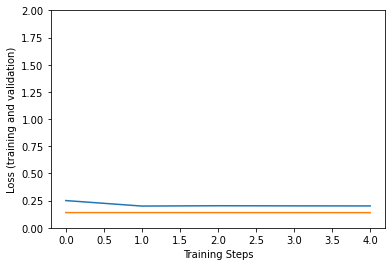

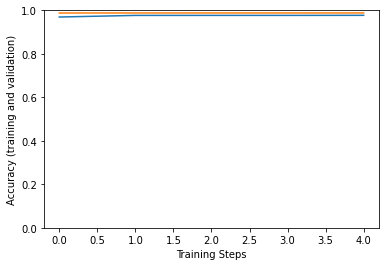

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImgSim/bit_feature_extractor/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImgSim/bit_feature_extractor/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImgSim/bit_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ImgSim/bit_model/assets


### 3. Image Vectorization
Now, we will use the encoder (prepared in step 2) to encode the images (prepared in step 1). We will save *feature vector* of each image as an array in a directory. After processing, we will save these embeddings for later use.

In [20]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

RuntimeError: empty_like method already has a different docstring

In [ ]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [ ]:
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [ ]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [ ]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [08:58<00:00,  9.28it/s]


### 4. Metadata and Indexing

We will assign a unique id to each image and create dictionaries to locate information of this image:
1) Image id to Image name dictionary,
2) Image id to image feature vector dictionary,
3) (optional) Image id to metadata product id dictionary.
We will also create an image id to image feature vector indexing. Then we will save these dictionaries and index object for later use.

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


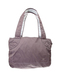

In [ ]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [ ]:
styles = pd.read_csv('/content/styles.csv', error_bad_lines=False)
styles['id'] = styles['id'].astype('str')
styles.to_csv(root_path+'/styles.csv', index=False)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [ ]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [ ]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:17, 279.67it/s]


In [ ]:
t.build(trees)
t.save('t.ann')

True

In [ ]:
file_path = '/content/drive/MyDrive/ImgSim/'

In [ ]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

## 5. Local Testing

We will load a random image and find top-K most similar images.

In [ ]:
from PIL import Image
import matplotlib.image as mpimg

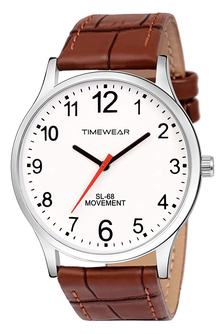

In [ ]:
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img

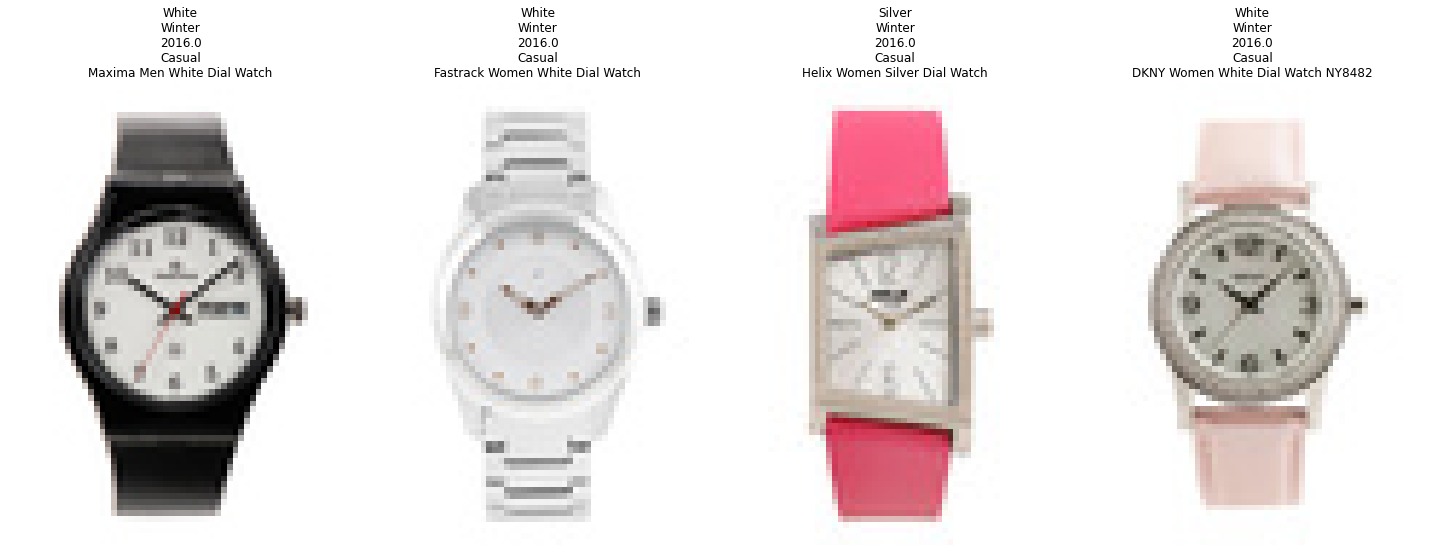

In [ ]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()

## 6. API Call

We will build two kinds of API - 1) UI based API using Streamlit, and 2) REST API using Flask. In both the cases, we will receive an image from user, encode it with our image encoder, find TopK similar vectors using Indexing object, and retrieve the image (and metadata) using dictionaries. We send these images (and metadata) back to the user.

In [ ]:
import os
import time

In [ ]:
root_path = '/content/drive/MyDrive/ImgSim'

In [ ]:
%%writefile utils.py

import os
import tensorflow as tf
from annoy import AnnoyIndex

root_path = '/content/drive/MyDrive/ImgSim'

class Encoder:
  encoder = tf.keras.models.load_model(os.path.join(root_path, 'bit_feature_extractor'))

class Indexer:
  dims = 256
  topK = 6
  indexer = AnnoyIndex(dims, 'angular')
  indexer.load(os.path.join(root_path, 'indexer.ann'))

encoder = Encoder()
indexer = Indexer()

Writing utils.py


### Streamlit App

In [ ]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer

root_path = '/content/drive/MyDrive/ImgSim'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(os.path.join(root_path, 'styles.csv'))

# load the mappings
file_index_to_file_name = pickle.load(open(os.path.join(root_path ,'file_index_to_file_name.p'), 'rb'))
file_index_to_file_vector = pickle.load(open(os.path.join(root_path ,'file_index_to_file_vector.p'), 'rb'))
file_index_to_product_id = pickle.load(open(os.path.join(root_path ,'file_index_to_product_id.p'), 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

st.title("Image Similarity App")

uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    image.save(query_path)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Top similar images...")

    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = []
    img_captions = []

    start_time = time.time()
    for i in nns:
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files.append(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions.append(img_caption)
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    st.image(img_files, caption=img_captions, width=200)

Writing app.py


In [ ]:
! pip install -q pyngrok
! pip install -q streamlit
! pip install -q colab-everything

from colab_everything import ColabStreamlit
ColabStreamlit('app.py')

### Flask API

#### server-side

In [ ]:
%%writefile flask_app.py

import pandas as pd
import numpy as np
from PIL import Image
from annoy import AnnoyIndex
import glob
import os
import tensorflow as tf
import tarfile
import pickle
from pathlib import Path
import time
from utils import encoder, indexer
import io
import base64

from flask import Flask, request, jsonify, send_file

_PPATH = '/content/drive/MyDrive/ImgSim/'

start_time = time.time()
encoder = encoder.encoder
print("---Encoder--- %s seconds ---" % (time.time() - start_time))

topK = 6

start_time = time.time()
t = indexer.indexer
print("---Indexer--- %s seconds ---" % (time.time() - start_time))

# load the meta data
meta_data = pd.read_csv(_PPATH+'styles.csv')

# load the mappings
file_index_to_file_name = pickle.load(open(_PPATH+'file_index_to_file_name.p', 'rb'))
file_index_to_file_vector = pickle.load(open(_PPATH+'file_index_to_file_vector.p', 'rb'))
file_index_to_product_id = pickle.load(open(_PPATH+'file_index_to_product_id.p', 'rb'))

# load image path mapping
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

query_path = '/content/user_query.jpg'

def get_encoded_img(img):
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    my_encoded_img = base64.encodebytes(img_byte_arr.getvalue()).decode('ascii')
    return my_encoded_img


app = Flask(__name__)

@app.route("/fashion", methods=["POST"])
def home():
    file = request.files['image']
    # Read the image via file.stream
    img = Image.open(file.stream)
    img.save(query_path)

    start_time = time.time()
    test_vec = np.squeeze(encoder(load_img(query_path)))
    print("---Encoding--- %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    nns = t.get_nns_by_vector(test_vec, n=topK)
    print("---SimilarityIndex--- %s seconds ---" % (time.time() - start_time))

    img_files = {}
    img_captions = {}

    start_time = time.time()
    for count, i in enumerate(nns):
      #image files
      img_path = str(path_dict[file_index_to_file_name[i]+'.jpg'])
      img_file = Image.open(img_path)
      img_files[count] = get_encoded_img(img_file)
      #image captions
      item_id = file_index_to_product_id[i]
      img_caption = '\n'.join([str(j) for j in list(meta_data.loc[item_id].values[-5:])])
      img_captions[count] = img_caption
    print("---Output--- %s seconds ---" % (time.time() - start_time))

    return jsonify(img_files)

app.run(debug=True)

In [ ]:
!nohup python3 -u flask_app.py &

nohup: appending output to 'nohup.out'


#### client-side

In [ ]:
from PIL import Image
from io import BytesIO
import base64
import requests

!wget -O 'img.jpg' -q 'https://images-na.ssl-images-amazon.com/images/I/61utX8kBDlL._UL1100_.jpg'

url = 'http://localhost:5000/fashion'
my_img = {'image': open('img.jpg', 'rb')}
r = requests.post(url, files=my_img)

imgs = []
for i in range(6):
  img = base64.decodebytes(r.json()[str(i)].encode('ascii'))
  img = Image.open(BytesIO(img)).convert('RGBA')
  imgs.append(img)

imgs[1]

In [ ]:
%%writefile ./ebsapp/requirements.txt
annoy==1.16.3
Pillow==2.2.2
click==7.1.2
Flask==1.1.2
itsdangerous==1.1.0
Jinja2==2.11.2
MarkupSafe==1.1.1
Werkzeug==1.0.1
numpy==1.18.5
pandas==1.0.5
pathlib==1.0.1
pip-tools==4.5.1
requests==2.23.0
scipy==1.4.1
tensorflow==2.0.0b1
tensorflow-hub==0.8.0
tqdm==4.41.1
urllib3==1.24.3
zipfile36==0.1.3

In [ ]:
%%writefile ./ebsapp/.ebextensions/01_packages.config
packages:
  yum:
    gcc-c++: []
    unixODBC-devel: []
files:
  "/etc/httpd/conf.d/wsgi_custom.conf":
    mode: "000644"
    owner: root
    group: root
    content: |
      WSGIApplicationGroup %{GLOBAL}